# LSTM baseline

from kuto

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [2]:
import os
import sys
import glob
import pickle
import random

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path


In [4]:
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [5]:
import pytorch_lightning as pl
# from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping

import wandb
from pytorch_lightning.loggers import WandbLogger

In [6]:
sys.path.append('../../')
import src.utils as utils

In [7]:
import multiprocessing
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm

from indoor_location_competition_20.io_f import read_data_file
import indoor_location_competition_20.compute_f as compute_f

In [8]:
DATA_DIR = Path("/home/knikaido/work/Indoor-Location-Navigation/data/")
WIFI_DIR = DATA_DIR / 'indoorunifiedwifids_original'
MLFLOW_DIR = DATA_DIR / 'mlflow/mlruns'
OUTPUT_DIR = Path('./output/')
MLFLOW_DIR = DATA_DIR / 'mlflow/mlruns'

## config

In [9]:
configs = {
    'loss':{
        'name': 'MSELoss',
        'params':{}
    },
    'optimizer':{
        'name': 'Adam',
        'params':{
            'lr': 0.01,
        }
    },

    'scheduler':{
        'name': 'ReduceLROnPlateau',
        'params':{
            'factor': 0.1,
            'patience': 3,
        }
    },

    'loader':{
        'train':{
            'batch_size': 512,
            'shuffle': True,
            'num_workers': 4,
        },
        'valid':{
            'batch_size': 512,
            'shuffle': False,
            'num_workers': 4,
        },
        'test':{
            'batch_size': 512,
            'shuffle': False,
            'num_workers': 4,
        }
    }
}

In [10]:
# config
config = configs

# globals variable
SEED = 777
MAX_EPOCHS = 500
N_SPLITS = 5
DEBUG = False
# EXP_MESSAGE = config['globals']['exp_message']

EXP_NAME = 44
IS_SAVE = True

utils.set_seed(SEED)

In [11]:
!wandb login e8aaf98060af90035c3c28a83b34452780aeec20

/bin/sh: 1: wandb: not found


## read data

In [12]:
train_df = pd.read_csv(WIFI_DIR / 'train_10_th10000_withdelta.csv')
test_df = pd.read_csv(WIFI_DIR / 'test_10_th10000_withdelta.csv')

In [13]:
sub = pd.read_csv(DATA_DIR/'indoor-location-navigation/sample_submission.csv', index_col=0)

BSSIDとRSSIは100ずつ存在しているけど全てが必要なわけではないみたい  
ここでは20だけ取り出している。

In [14]:
# training target features
NUM_FEATS = 80
BSSID_FEATS = [f'bssid_{i}' for i in range(NUM_FEATS)]
RSSI_FEATS  = [f'rssi_{i}' for i in range(NUM_FEATS)]
DELTA_FEATS  = ['delta_x', 'delta_y']

In [15]:
train_df.iloc[:, 100:110]

,bssid_0,bssid_1,bssid_2,bssid_3,bssid_4,bssid_5,bssid_6,bssid_7,bssid_8,bssid_9
0,e9b24f94c0007acb4b7169b945622efcd332cf6f,591ea59cf88e3397db5d60eb00a5147edd69399a,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,a77f8e93896f8fc8bc0d0700ca04b802ee79a07f,1b2fd184314ae440900fa9ce1addeb896b5604a9,2c09230bb32ee49f6a72928f6eeefb6885dc15ce,3799b46aa4cf6c3c45c0bc27d8f1efefea96914f,c71a2f5c4282d27f84b9b841db0e310ef0fcf6cd,4f8b7c168dc76c9d3b4ca7903042173e98fe2ddb,fc6956beb062b5158252c66953e92a0d25495cac
1,e9b24f94c0007acb4b7169b945622efcd332cf6f,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,591ea59cf88e3397db5d60eb00a5147edd69399a,d32dd11040b254cd889c9ead2d4a50f6e3900196,9c832009dfb1ee02053c9ce9b7770b6cd3191003,509d1f842b0773e85c6beec0bb530542efd35cb9,1b2fd184314ae440900fa9ce1addeb896b5604a9,2c09230bb32ee49f6a72928f6eeefb6885dc15ce,c71a2f5c4282d27f84b9b841db0e310ef0fcf6cd,fc6956beb062b5158252c66953e92a0d25495cac
2,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,e9b24f94c0007acb4b7169b945622efcd332cf6f,591ea59cf88e3397db5d60eb00a5147edd69399a,8c6ab78f2797e076f9106af81090d0ab9904f5cd,6e388d1db5ba8dd9de80522a4ddf50402cf443b3,ceccac4f0e50ec9e36e8d2800b8f2c7c3b4d903e,b2337b25e7d1df04928bf6698a9c0b2764df7795,509d1f842b0773e85c6beec0bb530542efd35cb9,76f81d5047273fa64a434457531d400fc5d90fac,f920a2e4cb52165850990d9d37d391b630f7de14
3,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,591ea59cf88e3397db5d60eb00a5147edd69399a,e9b24f94c0007acb4b7169b945622efcd332cf6f,6ec56c3efdeb067eb20bd2f4a6ccdae07d640cc1,d32dd11040b254cd889c9ead2d4a50f6e3900196,f920a2e4cb52165850990d9d37d391b630f7de14,6a42281c99a4cff2ce9dba3fc91ad6a431af64d9,9c832009dfb1ee02053c9ce9b7770b6cd3191003,509d1f842b0773e85c6beec0bb530542efd35cb9,0452e85d0a41780463cfe079077ea5bd2f519c7a
4,5875360455060f20a3cba705f44a4e3987c9b9f3,6ec56c3efdeb067eb20bd2f4a6ccdae07d640cc1,0452e85d0a41780463cfe079077ea5bd2f519c7a,3c7e7fa0576bc8a2af71d5899581df36f4dab6c8,09e103887f42552d20328aa41891cf82dace79ab,54bba3a36204f8c71b93798c31f9e0b039914575,18067f8d8861af3bcae51ba04b6b11b9150b9ff2,591ea59cf88e3397db5d60eb00a5147edd69399a,f920a2e4cb52165850990d9d37d391b630f7de14,d32dd11040b254cd889c9ead2d4a50f6e3900196
...,...,...,...,...,...,...,...,...,...,...
251108,5964a27e0cb3344b0a18540e6b3120c433971c38,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,cce41299a022ada08aebf3d309acb07d5f00b014,346b34a42e801c64e043dbaacbe7fef9b8880774,4b5dbdb52b131410ea10b59ea451de62280b41d6,fa11fc4d4960379cb68cc6968ba6415168fef53c,4d2e5639041b40b0df2ee258aa504bd904133d80,dfc21edb1f7650d5645fd672bbe6a13fc6fd77f8,5f583dcccc43b5b7ac25d270e29c92d878fb2be0,a94eb920c0a198fe8385f3de6a8e8e6d44b6f6c9
251109,5964a27e0cb3344b0a18540e6b3120c433971c38,346b34a42e801c64e043dbaacbe7fef9b8880774,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,cce41299a022ada08aebf3d309acb07d5f00b014,566e0c6e3bcf2b8b3d310d96f111043d17ace817,bd3fc24710537130e97dc2dab4a6bf70b3884a8b,4b5dbdb52b131410ea10b59ea451de62280b41d6,4d2e5639041b40b0df2ee258aa504bd904133d80,f4107af4418d57aacb3542343f7b47768debdc75,180a351ec58c07d60949862c534373c43f548a9a
251110,346b34a42e801c64e043dbaacbe7fef9b8880774,5964a27e0cb3344b0a18540e6b3120c433971c38,cce41299a022ada08aebf3d309acb07d5f00b014,566e0c6e3bcf2b8b3d310d96f111043d17ace817,bd3fc24710537130e97dc2dab4a6bf70b3884a8b,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,4b5dbdb52b131410ea10b59ea451de62280b41d6,a94eb920c0a198fe8385f3de6a8e8e6d44b6f6c9,ee5ca7a7deaacdcd5d99355ff5f156dc45b74efa,a7986c0cea5d2571ea42011ab4407039e977c0bd
251111,346b34a42e801c64e043dbaacbe7fef9b8880774,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,5964a27e0cb3344b0a18540e6b3120c433971c38,f4107af4418d57aacb3542343f7b47768debdc75,cce41299a022ada08aebf3d309acb07d5f00b014,4b5dbdb52b131410ea10b59ea451de62280b41d6,fa11fc4d4960379cb68cc6968ba6415168fef53c,a7986c0cea5d2571ea42011ab4407039e977c0bd,180a351ec58c07d60949862c534373c43f548a9a,4d2e5639041b40b0df2ee258aa504bd904133d80


bssid_NはN個目のBSSIDを示しておりRSSI値が大きい順に番号が振られている。
100個しかない


In [16]:
# get numbers of bssids to embed them in a layer

# train
wifi_bssids = []
# bssidを列ごとにリストに入れていく
for i in range(100, 200):
    wifi_bssids.extend(train_df.iloc[:,i].values.tolist())
wifi_bssids = list(set(wifi_bssids))

train_wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(train): {train_wifi_bssids_size}')

# test
wifi_bssids_test = []
for i in range(100, 200):
    wifi_bssids_test.extend(test_df.iloc[:,i].values.tolist())
wifi_bssids_test = list(set(wifi_bssids_test))

test_wifi_bssids_size = len(wifi_bssids_test)
print(f'BSSID TYPES(test): {test_wifi_bssids_size}')


wifi_bssids.extend(wifi_bssids_test)
wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(all): {wifi_bssids_size}')


BSSID TYPES(train): 61718
BSSID TYPES(test): 31253
BSSID TYPES(all): 92971


In [17]:
# get numbers of bssids to embed them in a layer

# train
rssi_bssids = []
# bssidを列ごとにリストに入れていく
for i in RSSI_FEATS:
    rssi_bssids.extend(train_df.loc[:,i].values.tolist())
rssi_bssids = list(set(rssi_bssids))

train_rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(train): {train_rssi_bssids_size}')

# test
rssi_bssids_test = []
for i in RSSI_FEATS:
    rssi_bssids_test.extend(test_df.loc[:,i].values.tolist())
rssi_bssids_test = list(set(rssi_bssids_test))

test_rssi_bssids_size = len(rssi_bssids_test)
print(f'RSSI TYPES(test): {test_rssi_bssids_size}')


rssi_bssids.extend(rssi_bssids_test)
rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(all): {rssi_bssids_size}')

RSSI TYPES(train): 93
RSSI TYPES(test): 77
RSSI TYPES(all): 170


## PreProcess

In [19]:
# preprocess

le = LabelEncoder()
le.fit(wifi_bssids)
le_site = LabelEncoder()
le_site.fit(train_df['site_id'])
le_rssi = LabelEncoder()
le_rssi.fit(rssi_bssids)

ss = StandardScaler()
ss.fit(train_df.loc[:,DELTA_FEATS])


def preprocess(input_df, le=le, le_site=le_site, ss=ss):
    output_df = input_df.copy()
    # RSSIの正規化
#     output_df.loc[:,RSSI_FEATS] = ss.transform(input_df.loc[:,RSSI_FEATS])

    # BSSIDのLE(1からふる)
    for i in BSSID_FEATS:
        output_df.loc[:,i] = le.transform(input_df.loc[:,i])
#         output_df.loc[:,i] = output_df.loc[:,i] + 1  # 0からではなく1から番号を振りたいため なぜ？
    for i in RSSI_FEATS:
        output_df.loc[:,i] = le_rssi.transform(input_df.loc[:,i])

    # site_idのLE
    output_df.loc[:, 'site_id'] = le_site.transform(input_df.loc[:, 'site_id'])

    # なぜ２重でやる？
    output_df.loc[:,DELTA_FEATS] = ss.transform(output_df.loc[:,DELTA_FEATS])
    return output_df

train = preprocess(train_df)
test = preprocess(test_df)

train  

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,frequency_99,wp_tmestamp,x,y,floor,floor_str,path_id,site_id,delta_x,delta_y
0,b7e6027447eb1f81327d66cfd3adbe557aabf26c,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,8c1562bec17e1425615f3402f72dded3caa42ce5,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,...,2452,1578469851129,157.99141,102.125390,-1.0,B1,5e158ef61506f2000638fd1f,0,-0.025217,-0.014531
1,b7e6027447eb1f81327d66cfd3adbe557aabf26c,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,da39a3ee5e6b4b0d3255bfef95601890afd80709,b7e6027447eb1f81327d66cfd3adbe557aabf26c,...,5320,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0,0.446463,0.506216
2,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,5745,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0,0.446463,0.506216
3,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,5180,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0,0.446463,0.506216
4,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,5731b8e08abc69d4c4d685c58164059207c93310,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,7182afc4e5c212133d5d7d76eb3df6c24618302b,...,5765,1578469862177,168.49713,109.861336,-1.0,B1,5e158ef61506f2000638fd1f,0,0.504093,0.398055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251108,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,4abd3985ba804364272767c04cdc211615f77c56,b5d43f6b4e1938ed497c7b589c6eae9ac0bee168,0a8a55cf161bc4980194ec9f7f7a448439be4b74,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,da39a3ee5e6b4b0d3255bfef95601890afd80709,1f09251bbfadafb11c63c87963af25238d6bc886,1556355684145fce5e67ba749d943a180266ad90,...,0,1573733061352,203.53165,143.513960,6.0,F7,5dcd5c9323759900063d590a,23,0.121631,0.362279
251109,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,4abd3985ba804364272767c04cdc211615f77c56,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,b5d43f6b4e1938ed497c7b589c6eae9ac0bee168,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,4abd3985ba804364272767c04cdc211615f77c56,1556355684145fce5e67ba749d943a180266ad90,...,0,1573733070079,192.57130,145.781450,6.0,F7,5dcd5c9323759900063d590a,23,-2.376529,0.568969
251110,4abd3985ba804364272767c04cdc211615f77c56,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd

In [20]:
site_count = len(train['site_id'].unique())
site_count

24

## PyTorch model
- embedding layerが重要  

In [36]:
# dataset
from torch.utils.data import Dataset, DataLoader
class IndoorDataset(Dataset):
    def __init__(self, df, phase='train'):
        self.df = df
        self.phase = phase
        self.bssid_feats = df[BSSID_FEATS].values.astype(int)
        self.rssi_feats = df[RSSI_FEATS].values.astype(int)
        self.delta_feats = df[DELTA_FEATS].values.astype(np.float32)
        self.site_id = df['site_id'].values.astype(int)

        if phase in ['train', 'valid']:
            self.xy = df[['x', 'y']].values.astype(np.float32)
            self.floor = df['floor'].values.astype(np.float32)
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        
        concat_feat = np.empty(2 * NUM_FEATS).astype(int)
        concat_feat[0::2] = self.bssid_feats[idx]
        concat_feat[1::2] = self.rssi_feats[idx]
        
        feature = {
            'RSSI_BSSID_FEATS':concat_feat,
            'site_id':self.site_id[idx],
            'delta':self.delta_feats[idx]
        }
        if self.phase in ['train', 'valid']:
            target = {
                'xy':self.xy[idx],
                'floor':self.floor[idx]
            }
        else:
            target = {}
        return feature, target

In [34]:
import torch
from torch import nn

class LSTMModel(nn.Module):
    def __init__(self, bssid_size=94248, site_size=24, embedding_dim=64):
        super(LSTMModel, self).__init__()
        
        # bssid
        # ->64次元に圧縮後sequence化にする
        # wifi_bssids_sizeが辞書の数を表す
        self.bssid_embedding = nn.Embedding(bssid_size, 64, max_norm=True)
        # site
        # ->2次元に圧縮後sequence化する
        # site_countが辞書の数を表す       
        self.site_embedding = nn.Embedding(site_size, 64, max_norm=True)

        # rssi
        # 次元を64倍に線形変換
#         self.rssi_embedding = nn.Embedding(rssi_size, 64, max_norm=True)
        self.delta = nn.Sequential(
            nn.BatchNorm1d(2),
            nn.Linear(2, 2 * 64)
        )
        
        concat_size = 64 + (2 * NUM_FEATS * 64) + 64 * 2
        self.linear_layer2 = nn.Sequential(
            nn.BatchNorm1d(concat_size),
            nn.Dropout(0.3),
            nn.Linear(concat_size, 256),
            nn.ReLU()
        )
        self.bn1 = nn.BatchNorm1d(concat_size)

        self.flatten = nn.Flatten()

        self.dropout1 = nn.Dropout(0.3)
        self.linear1 = nn.Linear(in_features=concat_size, out_features=256)#, bias=False)
        self.bn2 = nn.BatchNorm1d(256)

        self.batch_norm1 = nn.BatchNorm1d(1)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=128,dropout=0.3, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128,hidden_size=16,dropout=0.1, batch_first=True)

        self.fc_xy = nn.Linear(16, 2)
        # self.fc_x = nn.Linear(16, 1)
        # self.fc_y = nn.Linear(16, 1)
        self.fc_floor = nn.Linear(16, 1)

    
    def forward(self, x):
        # input embedding
        batch_size = x["site_id"].shape[0]
        x_bssid = self.bssid_embedding(x['RSSI_BSSID_FEATS'])
        x_bssid = self.flatten(x_bssid)
        
        x_site_id = self.site_embedding(x['site_id'])
        x_site_id = self.flatten(x_site_id)
        
        x_delta = self.delta(x['delta'])


        x = torch.cat([x_bssid, x_delta, x_site_id], dim=1)
        x = self.linear_layer2(x)

        # lstm layer
        x = x.view(batch_size, 1, -1)  # [batch, 1]->[batch, 1, 1]
        x = self.batch_norm1(x)
        x, _ = self.lstm1(x)
        x = torch.relu(x)
        x, _ = self.lstm2(x)
        x = torch.relu(x)

        # output [batch, 1, 1] -> [batch]
        # x_ = self.fc_x(x).view(-1)
        # y_ = self.fc_y(x).view(-1)
        xy = self.fc_xy(x).squeeze(1)
        floor = torch.relu(self.fc_floor(x)).view(-1)
        # return {"x":x_, "y":y_, "floor":floor} 
        return {"xy": xy, "floor": floor}

In [29]:
def mean_position_error(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def to_np(input):
    return input.detach().cpu().numpy()

In [30]:
def get_optimizer(model: nn.Module, config: dict):
    optimizer_config = config["optimizer"]
    optimizer_name = optimizer_config.get("name")
    base_optimizer_name = optimizer_config.get("base_name")
    optimizer_params = optimizer_config['params']

    if hasattr(optim, optimizer_name):
        optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_params)
        return optimizer
    else:
        base_optimizer = optim.__getattribute__(base_optimizer_name)
        optimizer = globals().get(optimizer_name)(
            model.parameters(), 
            base_optimizer,
            **optimizer_config["params"])
        return  optimizer

def get_scheduler(optimizer, config: dict):
    scheduler_config = config["scheduler"]
    scheduler_name = scheduler_config.get("name")

    if scheduler_name is None:
        return
    else:
        return optim.lr_scheduler.__getattribute__(scheduler_name)(
            optimizer, **scheduler_config["params"])


def get_criterion(config: dict):
    loss_config = config["loss"]
    loss_name = loss_config["name"]
    loss_params = {} if loss_config.get("params") is None else loss_config.get("params")
    if hasattr(nn, loss_name):
        criterion = nn.__getattribute__(loss_name)(**loss_params)
    else:
        criterion = globals().get(loss_name)(**loss_params)

    return criterion

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [31]:
# Learner class(pytorch-lighting)
class Learner(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        self.xy_criterion = get_criterion(config)
        self.f_criterion = get_criterion(config)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        loss = self.xy_criterion(output["xy"], y["xy"])
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        xy_loss = self.xy_criterion(output["xy"], y["xy"])
        f_loss = self.f_criterion(output["floor"], y["floor"])
        loss = xy_loss  # + f_loss
        mpe = mean_position_error(
            to_np(output['xy'][:, 0]), to_np(output['xy'][:, 1]), 0, 
            to_np(y['xy'][:, 0]), to_np(y['xy'][:, 1]), 0)
        
        # floor lossは現状は無視して良い
        self.log(f'Loss/val', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/xy', xy_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/floor', f_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'MPE/val', mpe, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        return mpe
    
    def validation_epoch_end(self, outputs):
        avg_loss = np.mean(outputs)
        print(f'epoch = {self.current_epoch}, mpe_loss = {avg_loss}')

    def configure_optimizers(self):
        optimizer = get_optimizer(self.model, self.config)
        scheduler = get_scheduler(optimizer, self.config)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "Loss/val"}

In [32]:
# oof
def evaluate(model, loaders, phase):
    x_list = []
    y_list = []
    f_list = []
    with torch.no_grad():
        for batch in loaders[phase]:
            x, y = batch
            output = model(x)
            x_list.append(to_np(output['xy'][:, 0]))
            y_list.append(to_np(output['xy'][:, 1]))
            f_list.append(to_np(output['floor']))

    x_list = np.concatenate(x_list)
    y_list = np.concatenate(y_list)
    f_list = np.concatenate(f_list)
    return x_list, y_list, f_list

## train

In [37]:
oofs = np.zeros((len(train), 2), dtype = np.float32)  # 全てのoofをdfで格納する
predictions = []  # 全ての予測値をdfで格納する
val_scores = []
# skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
gkf = GroupKFold(n_splits=N_SPLITS)
# for fold, (trn_idx, val_idx) in enumerate(skf.split(train.loc[:, 'path'], train.loc[:, 'path'])):
for fold, (trn_idx, val_idx) in enumerate(gkf.split(train.loc[:, 'path_id'], groups=train.loc[:, 'path_id'])):

    # 指定したfoldのみループを回す

    print('=' * 20)
    print(f'Fold {fold}')
    print('=' * 20)

    # train/valid data
    trn_df = train.loc[trn_idx, BSSID_FEATS + RSSI_FEATS + DELTA_FEATS + ['site_id', 'x','y','floor']].reset_index(drop=True)
    val_df = train.loc[val_idx, BSSID_FEATS + RSSI_FEATS + DELTA_FEATS + ['site_id', 'x','y','floor']].reset_index(drop=True)

    # data loader
    loaders = {}
    loader_config = config["loader"]
    loaders["train"] = DataLoader(IndoorDataset(trn_df, phase="train"), **loader_config["train"], worker_init_fn=worker_init_fn) 
    loaders["valid"] = DataLoader(IndoorDataset(val_df, phase="valid"), **loader_config["valid"], worker_init_fn=worker_init_fn)
    loaders["test"] = DataLoader(IndoorDataset(test, phase="test"), **loader_config["test"], worker_init_fn=worker_init_fn)
    
    # model
    model = LSTMModel(wifi_bssids_size+rssi_bssids_size, site_count)
    model_name = model.__class__.__name__
    
    # loggers
    RUN_NAME = f'exp{str(EXP_NAME)}'
    wandb.init(project='Indoor_Location_Navigation', entity='sqrt4kaido', group=RUN_NAME, job_type=RUN_NAME + f'-fold-{fold}')
    wandb.run.name = RUN_NAME + f'-fold-{fold}'
    wandb_config = wandb.config
    wandb_config.model_name = model_name
    wandb.watch(model)
    
    
    loggers = []
    loggers.append(WandbLogger())

    learner = Learner(model, config)
    
    # callbacks
    callbacks = []
    checkpoint_callback = ModelCheckpoint(
        monitor=f'Loss/val',
        mode='min',
        dirpath=OUTPUT_DIR,
        verbose=False,
        filename=f'{model_name}-{learner.current_epoch}-{fold}')
    callbacks.append(checkpoint_callback)

    early_stop_callback = EarlyStopping(
        monitor='Loss/val',
        min_delta=0.00,
        patience=20,
        verbose=True,
        mode='min')
    callbacks.append(early_stop_callback)
    
    trainer = pl.Trainer(
        logger=loggers,
        callbacks=callbacks,
        max_epochs=MAX_EPOCHS,
        default_root_dir=OUTPUT_DIR,
        gpus=1,
        fast_dev_run=DEBUG,
        deterministic=True,
        benchmark=True,
#         precision=16,
#         progress_bar_refresh_rate=0  # vscodeの時progress barの動作が遅いので表示しない
        )


    trainer.fit(learner, train_dataloader=loaders['train'], val_dataloaders=loaders['valid'])

    #############
    # validation (to make oof)
    #############
    model.eval()
    oof_x, oof_y, oof_f = evaluate(model, loaders, phase="valid")
    oofs[val_idx, 0] = oof_x
    oofs[val_idx, 1] = oof_y

    
    val_score = mean_position_error(
        oof_x, oof_y, 0,
        val_df['x'].values, val_df['y'].values, 0)
    val_scores.append(val_score)
    print(f"fold {fold}: mean position error {val_score}")

    #############
    # inference
    #############
    preds_x, preds_y, preds_f = evaluate(model, loaders, phase="test")
    test_preds = pd.DataFrame(np.stack((preds_f, preds_x, preds_y))).T
    test_preds.columns = sub.columns
    test_preds["site_path_timestamp"] = test["site_path_timestamp"]
    test_preds["floor"] = test_preds["floor"].astype(int)
    predictions.append(test_preds)
    

Fold 0


/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.6 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.6 M    Trainable params
0         Non-trainable params
11.6 M    Total params
46.216    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 165.76342010498047


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 137.8147006310521


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 114.12912372422684


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 98.19561175984413


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 88.98811502331641


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 84.44337730317532


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 82.64780470050587


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 62.09536867902121


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 56.991495688705065


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 54.51913760775729


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 52.45077493537659


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 50.697133020203836


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 49.63710225578946


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 48.77849568035586


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 48.182761893486585


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 47.357884929483994


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 34.03469641849658


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 25.759922186841045


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 21.27165455288357


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 8.156744836146872


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 8.153204804360419


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 8.39764029191126


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 8.33107693877344


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 8.104671599402264


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.881772780607983


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 8.347521778744522


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 7.959239550106197


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 8.095988723608132


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 8.139997159591829


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 7.271188623746851


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 7.15781938104816


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 7.1208792223664945


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 7.095951598561145


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 7.074239987238695


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 7.077724696384203


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 7.064993633292399


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 7.06120566468123


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 7.071668875952728


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 7.049947062590135


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 7.012659402040161


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 7.012550025505838


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 6.980783903596223


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 6.977010044158979


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 7.024220453291433


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 6.9829617831723905


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 7.005255643152663


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 6.960319544355407


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 7.005967908691596


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 6.978075008404631


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 6.9652290660899965


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 6.948484748710798


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 6.9755317178460166


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 6.957945997064764


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 6.958430005687809


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 6.965073781707275


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 6.920443622368575


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 6.906003583305092


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 6.9047705415446545


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 6.90450354645182


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 6.903349363493863


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 6.902426437231999


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 6.902157274697536


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 6.894322795609672


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 6.903132555486309


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 6.907554747544384


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 6.8930237798979785


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 6.8997178842194895


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 6.89641513548793


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 6.8951798153005575


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 6.899635591021205


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 6.911674707493883


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 6.891181349267557


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 6.896663080664725


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 6.89879184519376


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 6.908395839869886


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 6.899076535167321


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 6.902160395249843


Validating: 0it [00:00, ?it/s]

epoch = 98, mpe_loss = 6.895580850773772


Validating: 0it [00:00, ?it/s]

epoch = 99, mpe_loss = 6.900204482397263


Validating: 0it [00:00, ?it/s]

epoch = 100, mpe_loss = 6.905740763534917


Validating: 0it [00:00, ?it/s]

epoch = 101, mpe_loss = 6.897524999542285


Validating: 0it [00:00, ?it/s]

epoch = 102, mpe_loss = 6.9082220267306695


Validating: 0it [00:00, ?it/s]

epoch = 103, mpe_loss = 6.893997091952894


Validating: 0it [00:00, ?it/s]

epoch = 104, mpe_loss = 6.897382463200642


Validating: 0it [00:00, ?it/s]

epoch = 105, mpe_loss = 6.900371806380212


Validating: 0it [00:00, ?it/s]

epoch = 106, mpe_loss = 6.901696542194267
fold 0: mean position error 6.901032872066841
Fold 1


Loss/val,41.84306
Loss/xy,41.84306
Loss/floor,5.0506
MPE/val,6.90103
epoch,106
trainer/global_step,42050
_runtime,492
_timestamp,1619248887
_step,106


Loss/val,█▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▁▁▁▆▇█▇▇▇██████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
MPE/val,█▆▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.6 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.6 M    Trainable params
0         Non-trainable params
11.6 M    Total params
46.216    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 141.1334228515625


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 129.2614453281097


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 103.2348217565527


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 88.7019284599037


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 82.20557632134752


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 67.22810856040104


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 52.59765430022485


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 42.50680861010901


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 37.278203569277366


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 32.933635335570116


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 27.698199506218963


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 24.13820354282126


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 20.625725409817033


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 18.069301470464055


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 16.21944885860585


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 14.740709417229592


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 13.648365212286157


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 12.803872946844342


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 12.443113019997757


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 11.245773936045596


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 10.435745191297404


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 10.564111611419355


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 9.886327469192626


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 11.109076197214494


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 9.379265296492504


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 8.899833909573156


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 9.854027372725467


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 8.757685202822591


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 10.059382817423936


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 8.415028066346139


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 8.280881021910782


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 8.362609518027783


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 8.738173361006998


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 8.314880402964878


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.894938697052494


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 8.361914991333283


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 8.216052100142432


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 8.054198664028414


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 8.324443724497195


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.093269091740797


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 8.25607496975264


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 8.103992417989534


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 7.3110425776111265


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 7.221566893325271


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 7.17998563523398


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 7.170454241192881


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.145515546013713


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 7.11719663205158


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 7.108312609271032


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 7.087945642661926


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 7.097660650265183


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 7.087999251742991


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 7.10112381073677


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 7.111294673945912


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 7.059762046948419


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 7.051789903138597


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 7.046913794643157


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 7.040241724441008


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 7.044081158210662


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 7.0355620743919385


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 7.0356899160429816


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 7.028767728098433


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 7.035276059409559


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 7.030184025460102


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 7.024050922258526


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 7.031352746161291


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 7.037512460319606


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 7.030959380408294


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 7.0296474018584725


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 7.03123768513981


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 7.023562332442722


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 7.022934215339876


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 7.0249734344006916


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 7.022649959725716


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 7.025249692206482


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 7.03417772102069


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 7.018269746605361


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 7.0374333395795


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 7.021380862804374


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 7.026780143645972


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 7.031550323786388


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 7.029219180364751


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 7.033095625634094


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 7.020317033058133


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 7.018965556958197
fold 1: mean position error 7.003825561950948
Fold 2


Loss/val,39.74702
Loss/xy,39.74702
Loss/floor,5.2582
MPE/val,7.00383
epoch,83
trainer/global_step,33011
_runtime,385
_timestamp,1619249278
_step,83


Loss/val,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▁▁▄█████████████████████████████████████
MPE/val,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.6 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.6 M    Trainable params
0         Non-trainable params
11.6 M    Total params
46.216    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 170.30027770996094


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 126.38160370499402


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 101.0597002679959


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 86.99658081297359


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 80.97162709624543


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 79.37734541082392


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 79.44263071699243


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 56.7119022707977


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 51.89836831772274


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 47.0261170907659


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 42.084652477250465


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 37.54101063035366


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 32.9699463660861


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 27.411016977655745


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 23.26825901628335


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 20.19912961035064


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 18.347103463022677


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 15.752261254958073


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 16.00193521998504


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 13.155753209978796


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 13.275724899735524


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 11.708751357500972


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 11.110172912430409


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 10.981238959247056


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 10.058428322964014


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 9.935398603033923


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 9.779888043833015


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 9.547276459789625


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 9.377209859434416


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 9.093376354686475


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 9.107238733048545


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 8.944358230380123


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 8.821565630306306


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 9.259064296023093


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.525784884066882


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 8.645436653392997


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 10.003532753896641


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 8.34152960505712


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 8.135529491175332


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.568723229318696


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 8.230681527078524


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 8.36524463965512


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 8.368105132580316


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 8.224240042536637


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 8.147558487232798


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 7.9824528158185


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 8.186999635288542


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 8.052440550874028


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 7.91781583519974


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 8.391833117411466


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 14.655157541475475


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 7.994809914270627


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 7.7532065619249995


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 7.644788818105226


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 7.681967702702043


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 7.769420537798989


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 8.463276526043037


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 8.3698187762887


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 7.49306532000819


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 7.362749242690361


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 7.331479255804164


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 7.281041140098252


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 7.261451542364662


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 7.2415274103149505


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 7.230870256622761


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 7.217043379929766


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 7.200813233813957


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 7.206017079979483


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 7.193503236350463


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 7.19458403813821


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 7.1920810300202715


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 7.152434813292237


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 7.188506850728983


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 7.168874882483467


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 7.179130630239015


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 7.170145991333781


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 7.116287416215869


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 7.122118395066071


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 7.119194605671768


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 7.117500932504099


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 7.119007784654678


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 7.111990418045746


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 7.1128601996636815


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 7.116886818252685


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 7.111029478700704


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 7.109959278315747


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 7.109389650060776


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 7.110910892486572


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 7.1077280349944605


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 7.104112787347134


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 7.110370702802968


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 7.108680483041055


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 7.097976142863625


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 7.102020950284589


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 7.116434129058686


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 7.107083256772942


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 7.106738314842784


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 7.098972412327041


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 7.111150945101454


Validating: 0it [00:00, ?it/s]

epoch = 98, mpe_loss = 7.102719385342626


Validating: 0it [00:00, ?it/s]

epoch = 99, mpe_loss = 7.104780250535379


Validating: 0it [00:00, ?it/s]

epoch = 100, mpe_loss = 7.107828372579838


Validating: 0it [00:00, ?it/s]

epoch = 101, mpe_loss = 7.103364360017364


Validating: 0it [00:00, ?it/s]

epoch = 102, mpe_loss = 7.110863474910039


Validating: 0it [00:00, ?it/s]

epoch = 103, mpe_loss = 7.104479915373766


Validating: 0it [00:00, ?it/s]

epoch = 104, mpe_loss = 7.102045410401381


Validating: 0it [00:00, ?it/s]

epoch = 105, mpe_loss = 7.105952654452624


Validating: 0it [00:00, ?it/s]

epoch = 106, mpe_loss = 7.110585927143421


Validating: 0it [00:00, ?it/s]

epoch = 107, mpe_loss = 7.1019914585263555


Validating: 0it [00:00, ?it/s]

epoch = 108, mpe_loss = 7.105508765891473


Validating: 0it [00:00, ?it/s]

epoch = 109, mpe_loss = 7.1034993848671535


Validating: 0it [00:00, ?it/s]

epoch = 110, mpe_loss = 7.102928919149629


Validating: 0it [00:00, ?it/s]

epoch = 111, mpe_loss = 7.103599178081375
fold 2: mean position error 7.083705274944029
Fold 3


Loss/val,41.91545
Loss/xy,41.91545
Loss/floor,4.70265
MPE/val,7.08371
epoch,111
trainer/global_step,44015
_runtime,525
_timestamp,1619249809
_step,111


Loss/val,█▅▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▄▄▄▁▁▃▄▄▅▆▆▇▇███████████████████████████
MPE/val,█▆▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.6 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.6 M    Trainable params
0         Non-trainable params
11.6 M    Total params
46.216    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 129.3711929321289


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 124.44603104689794


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 98.23005311469211


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 79.71550824948973


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 68.16836868255977


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 57.3765587410908


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 44.342439996185774


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 36.455812390142746


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 31.614402817486148


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 27.1821635788242


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 24.017284733609355


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 21.04943039190052


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 17.589433573922623


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 15.770503744201593


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 13.777025199952122


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 12.63892563508695


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 11.457455901865066


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 14.10174940236577


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 11.9198479855537


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 10.7001677970903


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 10.03794712909335


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 9.551009667563658


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 9.36652272848063


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 9.351481528778478


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 9.050425681305603


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 8.896245209020012


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 9.833971837554316


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 8.720429056508529


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 8.618155303313431


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 8.528899787338249


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 8.916530589027053


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 8.46158258193514


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 8.56594491706483


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 8.531203320846256


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.954131669834826


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 8.29919612873632


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 8.319359485967984


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 8.136349160785366


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 8.777982906966447


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.709166399679741


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 8.029404597267751


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 7.834288851545733


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 8.421197035776506


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 8.102000396922852


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 8.050911288539934


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 8.377400967862242


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.462814990710835


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 7.320640283977457


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 7.2670801162300895


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 7.237371891593012


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 7.210948779073053


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 7.17841529469245


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 7.1779461124773665


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 7.179482484523486


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 7.168587676464176


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 7.130671478124056


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 7.147834009280265


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 7.158560765433532


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 7.1508187761838675


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 7.149812935421641


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 7.108921377293416


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 7.098417912652003


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 7.092891378155601


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 7.090226508673734


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 7.084273367635922


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 7.0864049493088554


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 7.0897116765779105


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 7.0898328884997595


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 7.085053249571897


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 7.082712515017208


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 7.090617601212881


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 7.086332820202104


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 7.084454249958748


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 7.084962561301197


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 7.080876068949543


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 7.082480828700278


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 7.082147460052933


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 7.091151895678038


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 7.090365104733929


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 7.081068282699083


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 7.084869186240537


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 7.084947286387206


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 7.0814065231688454


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 7.08018208366766


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 7.081335780177663


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 7.081707918178004


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 7.076476268617532


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 7.082052139949003


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 7.084061581364942


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 7.083276136538204


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 7.079358133350384


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 7.077465654833044


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 7.081433704562182


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 7.083515399058346


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 7.0799463889449115


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 7.083477176905831


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 7.079809487677479


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 7.083053562899772


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 7.084093808394856


Validating: 0it [00:00, ?it/s]

epoch = 98, mpe_loss = 7.083929831069659


Validating: 0it [00:00, ?it/s]

epoch = 99, mpe_loss = 7.081814724466074


Validating: 0it [00:00, ?it/s]

epoch = 100, mpe_loss = 7.08783777083647


Validating: 0it [00:00, ?it/s]

epoch = 101, mpe_loss = 7.082915874652083


Validating: 0it [00:00, ?it/s]

epoch = 102, mpe_loss = 7.080166367307587


Validating: 0it [00:00, ?it/s]

epoch = 103, mpe_loss = 7.084739554593267


Validating: 0it [00:00, ?it/s]

epoch = 104, mpe_loss = 7.080052099156704


Validating: 0it [00:00, ?it/s]

epoch = 105, mpe_loss = 7.085978808086798
fold 3: mean position error 7.016390102687115
Fold 4


Loss/val,39.2273
Loss/xy,39.2273
Loss/floor,4.99576
MPE/val,7.01639
epoch,105
trainer/global_step,41657
_runtime,491
_timestamp,1619250306
_step,105


Loss/val,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,██▁▃▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
MPE/val,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.6 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.6 M    Trainable params
0         Non-trainable params
11.6 M    Total params
46.216    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 127.78054809570312


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 119.87089019644716


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 93.33927773570721


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 74.9519366438995


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 63.88714844289452


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 51.58901589661247


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 44.394660040428626


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 36.640986452198995


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 30.194286559410244


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 26.10229458408917


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 21.94536347445763


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 19.147052567414562


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 16.95877463722313


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 15.406959015180732


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 14.082548243045597


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 12.861970175448667


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 12.534453290043874


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 10.956641072393458


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 10.473927388130495


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 11.879257390621623


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 9.630837223955975


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 9.312034307470645


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 9.304815401672846


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 9.014001658887365


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 8.946990599692993


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 8.470583617503987


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 8.455177650150103


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 8.635151198416045


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 8.543627476137251


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 8.34636204296107


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 8.686009359087501


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 8.481538945140679


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 8.532687377133911


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 8.303088164716947


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.12002423755108


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 8.152425298158883


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 8.175174706642911


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 8.475617638480314


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 8.117792351286717


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.496646930525372


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 8.345998239663801


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 8.06056095143395


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 7.8656506779217965


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 7.9701714626675795


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 8.396309708732232


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 8.154968289989728


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 8.28891705210187


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 7.418547199334709


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 7.3290421765888265


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 7.269288798618274


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 7.252682697683978


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 7.198951511567341


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 7.207488327838896


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 7.190789255385971


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 7.197691080598491


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 7.215524790734118


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 7.18365530261985


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 7.181663440307296


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 7.173955864271784


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 7.142352221459215


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 7.168313735087398


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 7.178933989441495


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 7.175046576079852


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 7.165332716915447


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 7.13347177731661


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 7.116861083500209


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 7.121667596505407


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 7.117595114831502


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 7.100560874126436


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 7.103099169833753


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 7.105254723411094


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 7.101974774935709


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 7.107449897926107


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 7.092611379774191


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 7.101986146779452


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 7.0921040090176435


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 7.104747561964488


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 7.090853049873416


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 7.096464176580055


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 7.1074604698058845


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 7.102467939735349


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 7.101433541934951


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 7.094593073225461


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 7.09930638498416


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 7.0902086707338405


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 7.097961479077279


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 7.094167583492381


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 7.1014225344727


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 7.0981396022573815


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 7.093790292425746


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 7.105316497801059


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 7.093155164387753


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 7.093558741600093


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 7.098876850092992


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 7.0933818182612285


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 7.090877751378464


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 7.093135523178309


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 7.0982424090397584
fold 4: mean position error 7.121683146456135


In [38]:
oofs_df = pd.DataFrame(oofs, columns=['x', 'y'])
oofs_df['path'] = train_df['path_id']
oofs_df['timestamp'] = train_df['wp_tmestamp']
oofs_df['site'] = train_df['site_id']
oofs_df['site_path_timestamp'] = oofs_df['site'] + '_' + oofs_df['path'] + '_' + oofs_df['timestamp'].astype(str)
oofs_df['floor'] = train_df['floor']
oofs_df.to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}.csv", index=False)
oofs_df

,x,y,path,timestamp,site,site_path_timestamp,floor
0,159.438568,105.116608,5e158ef61506f2000638fd1f,1578469851129,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
1,161.204346,106.905182,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
2,165.412079,111.165237,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
3,163.069275,110.560455,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
4,162.565750,112.829407,5e158ef61506f2000638fd1f,1578469862177,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
...,...,...,...,...,...,...,...
251108,192.900299,136.994827,5dcd5c9323759900063d590a,1573733061352,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
251109,190.257202,140.584412,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
251110,188.075165,142.789398,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
251111,188.601074,139.848221,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0


In [39]:
oofs_score = mean_position_error(
        oofs_df['x'], oofs_df['y'], 0,
        train_df['x'].values, train_df['y'].values, 0)
print(f"CV:{oofs_score}")

CV:7.025327043496998


In [40]:
all_preds = pd.concat(predictions).groupby('site_path_timestamp').mean()
all_preds

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0,85.231407,104.831749
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0,81.531555,102.583160
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0,83.147240,105.956802
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0,87.805969,107.915726
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0,88.556297,108.359535
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,0,210.563492,100.190887
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,0,208.573593,103.088188
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,0,205.860336,106.437042


In [41]:
all_preds_37 = pd.read_csv('../37/output/sub37.csv', index_col=0)
all_preds_37.index = pd.read_csv(WIFI_DIR / 'test_7_th20000.csv')['site_path_timestamp']
all_preds_37

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0,88.266884,104.794300
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0,82.316630,104.338745
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0,84.221380,105.362060
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0,87.842510,109.344190
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0,87.390120,108.134900
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,5,214.121280,98.048190
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,5,211.845250,100.757540
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,5,208.958570,107.238950


In [42]:
all_preds_merge = pd.merge(all_preds_37, all_preds, how='left', on='site_path_timestamp')[['floor_y', 'x_y', 'y_y']]
all_preds_merge = all_preds_merge.rename(columns={'floor_y': 'floor', 'x_y': 'x', 'y_y': 'y'})
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0.0,85.231407,104.831749
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0.0,81.531555,102.583160
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0.0,83.147240,105.956802
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0.0,87.805969,107.915726
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0.0,88.556297,108.359535
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,0.0,210.563492,100.190887
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,0.0,208.573593,103.088188
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,0.0,205.860336,106.437042


In [43]:
all_preds_merge['floor'].fillna(all_preds_37['floor'], inplace=True)
all_preds_merge['x'].fillna(all_preds_37['x'], inplace=True)
all_preds_merge['y'].fillna(all_preds_37['y'], inplace=True)
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0.0,85.231407,104.831749
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0.0,81.531555,102.583160
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0.0,83.147240,105.956802
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0.0,87.805969,107.915726
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0.0,88.556297,108.359535
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,0.0,210.563492,100.190887
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,0.0,208.573593,103.088188
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,0.0,205.860336,106.437042


In [44]:
# foldの結果を平均した後、reindexでsubmission fileにindexを合わせる
all_preds_merge.index = sub.index
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0.0,85.231407,104.831749
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0.0,81.531555,102.583160
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0.0,83.147240,105.956802
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0.0,87.805969,107.915726
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0.0,88.556297,108.359535
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,0.0,210.563492,100.190887
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,0.0,208.573593,103.088188
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,0.0,205.860336,106.437042


In [45]:
# floorの数値を置換
simple_accurate_99 = pd.read_csv('../01/submission.csv')
all_preds_merge['floor'] = simple_accurate_99['floor'].values
all_preds_merge.to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}.csv")
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,85.231407,104.831749
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,81.531555,102.583160
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,83.147240,105.956802
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,87.805969,107.915726
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,88.556297,108.359535
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,210.563492,100.190887
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,208.573593,103.088188
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,205.860336,106.437042


# Post Proccess

In [46]:
oofs_df = pd.read_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}.csv")
sub_df = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}.csv")

In [47]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions

In [48]:
def correct_path(args):

    path, path_df = args
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    txt_path = path_df['txt_path'].values[0]
    
    example = read_data_file(txt_path)
    rel_positions = compute_rel_positions(example.acce, example.ahrs)
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })

In [49]:
tmp = sub_df['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
sub_df['site'] = tmp[0]
sub_df['path'] = tmp[1]
sub_df['timestamp'] = tmp[2].astype(float)

In [50]:
used_buildings = sorted(sub_df['site'].value_counts().index.tolist())
test_txts = sorted(glob.glob(str(DATA_DIR/'indoor-location-navigation') + f'/test/*.txt'))
train_txts = [sorted(glob.glob(str(DATA_DIR/'indoor-location-navigation') + f'/train/{used_building}/*/*.txt')) for used_building in used_buildings]
train_txts = sum(train_txts, [])

In [51]:
txt_pathes = []
for path in tqdm(sub_df['path'].values):
    txt_pathes.append([test_txt for test_txt in test_txts if path in test_txt][0])


100%|██████████| 10133/10133 [00:00<00:00, 29040.22it/s][A


In [52]:
sub_df['txt_path'] = txt_pathes

In [53]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, sub_df.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
sub_df_cm = pd.concat(dfs).sort_values('site_path_timestamp')


0it [00:00, ?it/s]
1it [00:00,  1.32it/s]
4it [00:00,  5.55it/s]
6it [00:01,  7.24it/s]
9it [00:01, 10.13it/s]
11it [00:01, 10.90it/s]
13it [00:01,  7.79it/s]
15it [00:01,  8.77it/s]
17it [00:02,  8.36it/s]
19it [00:02,  9.41it/s]
21it [00:02,  9.62it/s]
23it [00:03,  6.68it/s]
24it [00:03,  6.05it/s]
28it [00:03, 10.22it/s]
30it [00:03, 11.04it/s]
33it [00:03, 13.00it/s]
35it [00:03, 12.69it/s]
37it [00:04, 11.35it/s]
40it [00:04, 10.45it/s]
43it [00:04, 11.00it/s]
45it [00:04, 11.86it/s]
47it [00:05, 10.67it/s]
49it [00:05,  8.78it/s]
50it [00:05,  8.35it/s]
51it [00:05,  7.57it/s]
55it [00:05, 12.99it/s]
57it [00:06, 10.05it/s]
60it [00:06,  9.87it/s]
62it [00:06,  9.57it/s]
64it [00:07,  8.67it/s]
66it [00:07,  8.00it/s]
68it [00:07,  8.92it/s]
70it [00:07,  9.25it/s]
72it [00:08,  7.99it/s]
74it [00:08,  9.43it/s]
77it [00:08,  9.42it/s]
79it [00:08,  8.73it/s]
81it [00:08,  9.48it/s]
83it [00:09,  9.64it/s]
85it [00:09,  8.82it/s]
87it [00:09,  9.21it/s]
88it [00:09,  9.31it/s]


In [54]:
txt_pathes = []
for path in tqdm(oofs_df['path'].values):
    txt_pathes.append([train_txt for train_txt in train_txts if path in train_txt][0])


100%|██████████| 251113/251113 [02:26<00:00, 1717.66it/s]


In [55]:
oofs_df['txt_path'] = txt_pathes

In [56]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, oofs_df.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
oofs_df_cm = pd.concat(dfs).sort_index()
oofs_df_cm


0it [00:00, ?it/s]
1it [00:00,  4.84it/s]
4it [00:00, 10.60it/s]
8it [00:00, 15.96it/s]
14it [00:00, 25.43it/s]
17it [00:01,  7.70it/s]
19it [00:02,  7.37it/s]
22it [00:02,  9.03it/s]
25it [00:02, 11.36it/s]
27it [00:02, 11.24it/s]
30it [00:02, 12.45it/s]
34it [00:02, 16.03it/s]
37it [00:02, 18.01it/s]
40it [00:03, 17.68it/s]
43it [00:03, 18.43it/s]
47it [00:03, 19.75it/s]
52it [00:03, 22.50it/s]
55it [00:03, 18.61it/s]
58it [00:04, 18.21it/s]
63it [00:04, 22.12it/s]
67it [00:04, 24.26it/s]
70it [00:04, 25.12it/s]
73it [00:04, 16.82it/s]
78it [00:04, 19.73it/s]
82it [00:05, 23.01it/s]
87it [00:05, 28.12it/s]
91it [00:05, 26.10it/s]
94it [00:05, 24.33it/s]
97it [00:05, 14.48it/s]
100it [00:06, 14.74it/s]
103it [00:06, 16.74it/s]
106it [00:06, 14.71it/s]
108it [00:06, 10.79it/s]
111it [00:07, 12.16it/s]
114it [00:07, 14.23it/s]
118it [00:07, 17.56it/s]
121it [00:07, 18.97it/s]
124it [00:07, 15.74it/s]
127it [00:07, 15.91it/s]
129it [00:08, 12.66it/s]
132it [00:08, 13.74it/s]
134it [00:0

,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,159.033972,105.823822
1,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.279670,109.467789
2,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.280590,109.472275
3,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.277214,109.474438
4,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,165.818575,112.338572
...,...,...,...,...
251108,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,205.464898,136.271249
251109,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,188.620326,140.463174
251110,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,188.612709,140.464809
251111,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,188.605829,140.463254


In [57]:
oofs_df_cm.to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_cm.csv", index=False)

In [58]:
oofs_score = mean_position_error(
        oofs_df_cm['x'], oofs_df_cm['y'], 0,
        train_df['x'].values, train_df['y'].values, 0)
print(f"CV:{oofs_score}")

CV:5.613131487858765


In [59]:
sub_df_cm.to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_cm.csv", index=False)

In [60]:
oofs_df_cm = pd.read_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_cm.csv")

In [61]:
sub_df_cm = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_cm.csv")

In [62]:
def split_col(df):
    df = pd.concat([
        df['site_path_timestamp'].str.split('_', expand=True) \
        .rename(columns={0:'site',
                         1:'path',
                         2:'timestamp'}),
        df
    ], axis=1).copy()
    return df
def sub_process(sub, train_waypoints):
    train_waypoints['isTrainWaypoint'] = True
    sub = split_col(sub[['site_path_timestamp','floor','x','y']]).copy()
    sub = sub.merge(train_waypoints[['site','floorNo','floor']].drop_duplicates(), how='left')
    sub = sub.merge(
        train_waypoints[['x','y','site','floor','isTrainWaypoint']].drop_duplicates(),
        how='left',
        on=['site','x','y','floor']
             )
    sub['isTrainWaypoint'] = sub['isTrainWaypoint'].fillna(False)
    return sub.copy()

In [63]:
train_waypoints = pd.read_csv(str(DATA_DIR/'indoor-location-navigation') + '/train_waypoints.csv')


In [64]:
sub_df_cm = sub_process(sub_df_cm, train_waypoints)
oofs_df_cm = sub_process(oofs_df_cm, train_waypoints)

In [65]:
from scipy.spatial.distance import cdist

def add_xy(df):
    df['xy'] = [(x, y) for x,y in zip(df['x'], df['y'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

sub_df_cm = add_xy(sub_df_cm)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(sub_df_cm.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

sub_df_cm_ds = pd.concat(ds)


oofs_df_cm = add_xy(oofs_df_cm)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(oofs_df_cm.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

oofs_df_cm_ds = pd.concat(ds)


  0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [66]:
def snap_to_grid(sub, threshold):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_x_'] = sub['x']
    sub['_y_'] = sub['y']
    sub.loc[sub['dist'] < threshold, '_x_'] = sub.loc[sub['dist'] < threshold]['x_']
    sub.loc[sub['dist'] < threshold, '_y_'] = sub.loc[sub['dist'] < threshold]['y_']
    return sub.copy()



In [67]:
# Calculate the distances
sub_df_cm_ds['dist'] = np.sqrt( (sub_df_cm_ds.x-sub_df_cm_ds.x_)**2 + (sub_df_cm_ds.y-sub_df_cm_ds.y_)**2 )
sub_pp = snap_to_grid(sub_df_cm_ds, threshold=5)
sub_pp = sub_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
    .rename(columns={'_x_':'x', '_y_':'y'})

# Calculate the distances
oofs_df_cm_ds['dist'] = np.sqrt( (oofs_df_cm_ds.x-oofs_df_cm_ds.x_)**2 + (oofs_df_cm_ds.y-oofs_df_cm_ds.y_)**2 )
oofs_pp = snap_to_grid(oofs_df_cm_ds, threshold=5)
oofs_pp = oofs_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
    .rename(columns={'_x_':'x', '_y_':'y'})

In [68]:
sub_pp = sub_pp.sort_index()
sub_pp

,site_path_timestamp,floor,x,y,site,path,floorNo
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,93.728470,97.948860,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,79.662285,102.766754,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,80.718400,107.197110,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.657740,110.509090,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.657740,110.509090,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
...,...,...,...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,206.627910,102.635210,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,206.627910,102.635210,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,206.334900,111.250860,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,195.733580,120.708420,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6


In [69]:
sub_pp[['site_path_timestamp','floor','x','y']] \
    .to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_pp.csv", index=False)

In [70]:
oofs_pp = oofs_pp.sort_index()
oofs_pp

,site_path_timestamp,floor,x,y,site,path,floorNo
0,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,158.49695,107.122680,5a0546857ecc773753327266,5e158ef61506f2000638fd1f,B1
1,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.33182,110.822685,5a0546857ecc773753327266,5e158ef61506f2000638fd1f,B1
2,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.33182,110.822685,5a0546857ecc773753327266,5e158ef61506f2000638fd1f,B1
3,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.33182,110.822685,5a0546857ecc773753327266,5e158ef61506f2000638fd1f,B1
4,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,168.49713,109.861336,5a0546857ecc773753327266,5e158ef61506f2000638fd1f,B1
...,...,...,...,...,...,...,...
251108,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,201.46214,138.499190,5dc8cea7659e181adb076a3f,5dcd5c9323759900063d590a,F7
251109,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,191.65205,141.780470,5dc8cea7659e181adb076a3f,5dcd5c9323759900063d590a,F7
251110,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,191.65205,141.780470,5dc8cea7659e181adb076a3f,5dcd5c9323759900063d590a,F7
251111,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,191.65205,141.780470,5dc8cea7659e181adb076a3f,5dcd5c9323759900063d590a,F7


In [71]:
oofs_score = mean_position_error(
        oofs_pp['x'], oofs_pp['y'], 0,
        train_df['x'].values, train_df['y'].values, 0)
print(f"CV:{oofs_score}")

CV:5.147643689847836


In [72]:
oofs_pp[['site_path_timestamp','floor','x','y']] \
    .to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_pp.csv", index=False)

In [73]:
wandb.init(project='Indoor_Location_Navigation', entity='sqrt4kaido', group=RUN_NAME, job_type='summary')
wandb.run.name = 'summary'
wandb.log({'CV_score': oofs_score})
wandb.save(utils.get_notebook_path())
wandb.finish()

Loss/val,42.41582
Loss/xy,42.41582
Loss/floor,4.79096
MPE/val,7.12168
epoch,96
trainer/global_step,38120
_runtime,455
_timestamp,1619250767
_step,96


Loss/val,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,█▇▁▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MPE/val,█▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


CV_score,5.14764
_runtime,2
_timestamp,1619251624
_step,0


CV_score,▁
_runtime,▁
_timestamp,▁
_step,▁


In [76]:
import json
import matplotlib.pylab as plt

def plot_preds(
    site,
    floorNo,
    sub=None,
    true_locs=None,
    base=str(DATA_DIR/'indoor-location-navigation'),
    show_train=True,
    show_preds=True,
    fix_labels=True,
    map_floor=None
):
    """
    Plots predictions on floorplan map.
    
    map_floor : use a different floor's map
    """
    if map_floor is None:
        map_floor = floorNo
    # Prepare width_meter & height_meter (taken from the .json file)
    floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
    json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
    with open(json_plan_filename) as json_file:
        json_data = json.load(json_file)

    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    floor_img = plt.imread(f"{base}/metadata/{site}/{map_floor}/floor_image.png")

    fig, ax = plt.subplots(figsize=(12, 12))
    plt.imshow(floor_img)

    if show_train:
        true_locs = true_locs.query('site == @site and floorNo == @map_floor').copy()
        true_locs["x_"] = true_locs["x"] * floor_img.shape[0] / height_meter
        true_locs["y_"] = (
            true_locs["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        true_locs.query("site == @site and floorNo == @map_floor").groupby("path").plot(
            x="x_",
            y="y_",
            style="+",
            ax=ax,
            label="train waypoint location",
            color="grey",
            alpha=0.5,
        )

    if show_preds:
        sub = sub.query('site == @site and floorNo == @floorNo').copy()
        sub["x_"] = sub["x"] * floor_img.shape[0] / height_meter
        sub["y_"] = (
            sub["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        for path, path_data in sub.query(
            "site == @site and floorNo == @floorNo"
        ).groupby("path"):
            path_data.plot(
                x="x_",
                y="y_",
                style=".-",
                ax=ax,
                title=f"{site} - floor - {floorNo}",
                alpha=1,
                label=path,
            )
    if fix_labels:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(
            by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
        )
    return fig, ax

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'5a0546857ecc773753327266 - floor - F1'}, xlabel='x_'>)

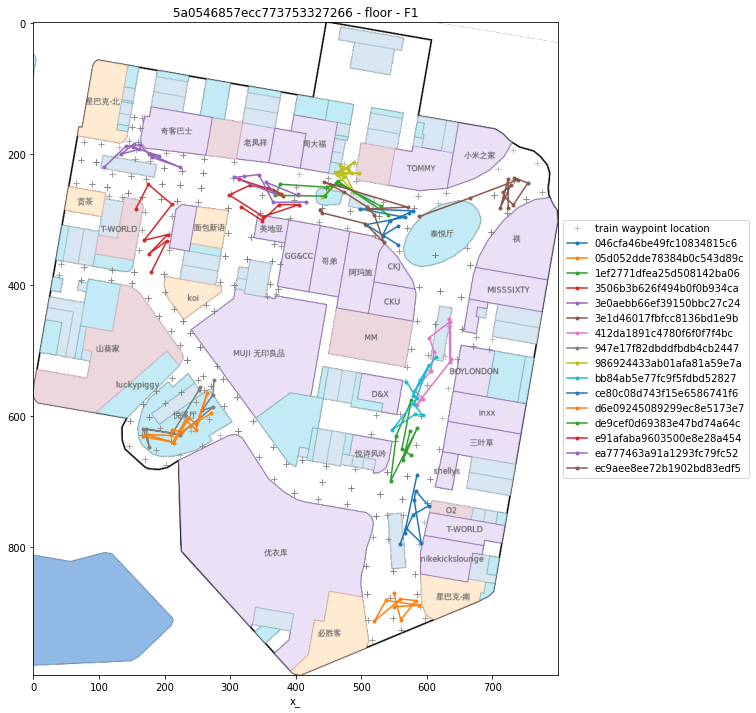

In [77]:
example_site = '5a0546857ecc773753327266'
example_floorNo = 'F1'

sub_df = sub_process(sub_df, train_waypoints)
plot_preds(example_site, example_floorNo, sub_df,
           train_waypoints, show_preds=True)

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'5a0546857ecc773753327266 - floor - F1'}, xlabel='x_'>)

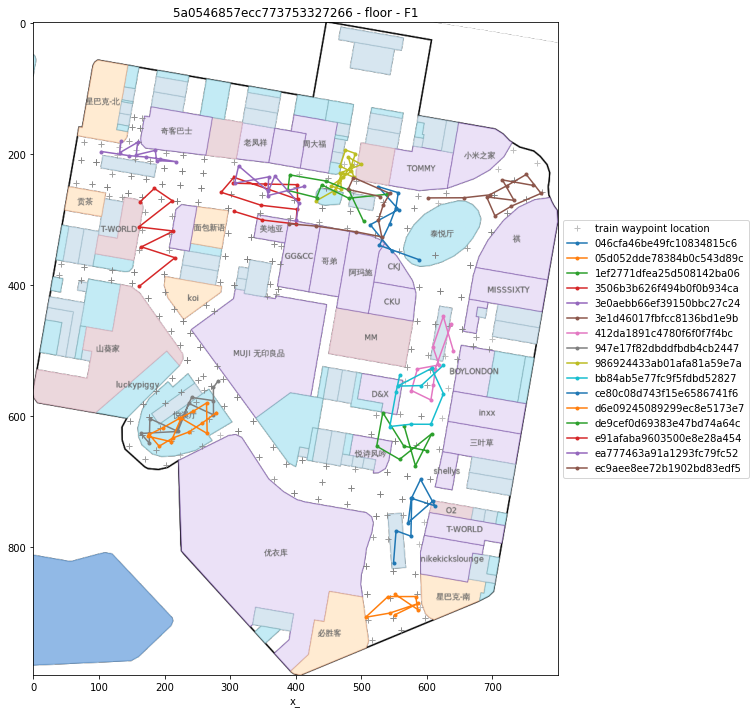

In [78]:
plot_preds(example_site, example_floorNo, sub_df_cm,
           train_waypoints, show_preds=True)

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'5a0546857ecc773753327266 - floor - F1'}, xlabel='x_'>)

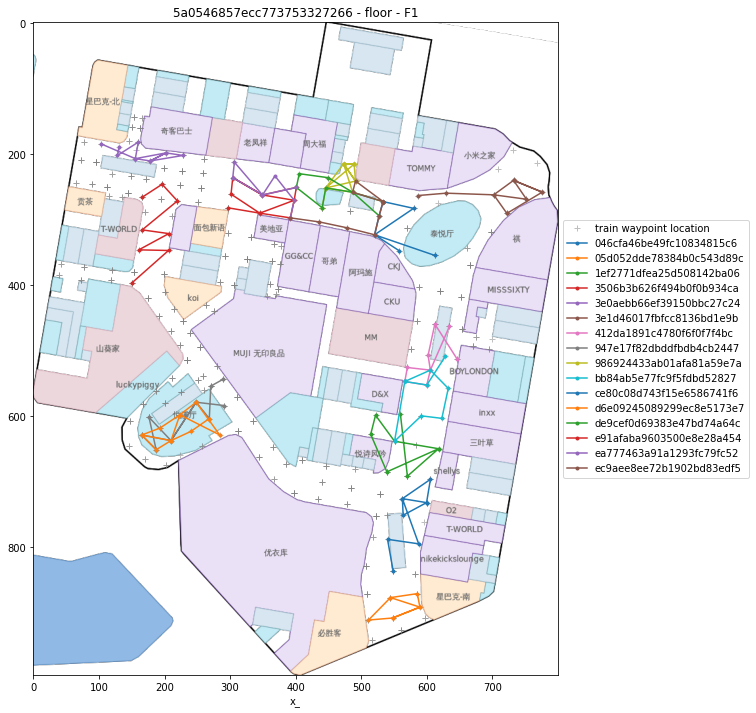

In [79]:
plot_preds(example_site, example_floorNo, sub_pp,
           train_waypoints, show_preds=True)